In [1]:
import tinyarray as ta
import numpy as np
import matplotlib.pyplot as plt
import importlib
import json
import kwant

from codes.gate_design import gate_coords
from codes.constants import scale
import codes.trijunction as trijunction
import codes.optimization as optimization
import codes.parameters as parameters
from codes.tools import hamiltonian
from codes.utils import eigsh, svd_transformation, dict_update, dep_acc_index
from codes.utils import order_wavefunctions

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [2]:
from scipy.optimize import minimize, minimize_scalar

In [3]:
with open('/home/tinkerer/trijunction-design/codes/config.json', 'r') as f:
    config = json.load(f)

change_config = [
    {"device": {"thickness": {"dielectric": 1.0}}},
    {"gate": {"channel_width": 13.0, 'angle': np.pi/6, 'gap': 2}},
]

for local_config in change_config:
    config = dict_update(config, local_config)

In [4]:
system = trijunction.Trijunction(config)

In [5]:
system.make_system()

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


100%|██████████| 13/13 [00:32<00:00,  2.51s/it]


In [7]:
pair = 'left-right'
voltages = parameters.pair_voltages()

In [8]:
zero_potential = dict(
    zip(
        ta.array(system.site_coords[:, [0, 1]] - system.offset),
        np.zeros(len(system.site_coords)),
    )
)

In [9]:
kwant_args = list(system.optimiser_arguments().values())
kwant_args[-1] = kwant_args[-1][order_wavefunctions(pair)]

In [10]:
x = [-3.0e-3, -3.0e-3, -7.0e-3, 3e-3]
voltages = parameters.voltage_dict(x)

In [11]:
params = parameters.junction_parameters()
params.update(voltages)
params.update(potential=zero_potential)

In [12]:
opt_args = tuple([pair, params, kwant_args])

In [13]:
%%time

sol = minimize_scalar(
    optimization.loss,
    0.2, 
    args=opt_args, 
    bounds=(0, 2), 
    method="bounded"
)

CPU times: user 48.4 s, sys: 12 s, total: 1min
Wall time: 1min


In [14]:
sol.x

1.3698359530326412

In [15]:
optimal_phase = parameters.phase_pairs(opt_args[0], 
                                       sol.x * np.pi)

In [16]:
optimal_phase

{'phi1': 4.303466566670519, 'phi2': 0}

In [17]:
# loss to optimize voltages
params.update(optimal_phase)

[-20.5   0. ]
[20.5  0. ]
[ 0.  76.5]
[-20.  24.]
[-5.5  7.5]
[5.5 7.5]
[20. 24.]
[-16.5  57.5]
[16.5 57.5]


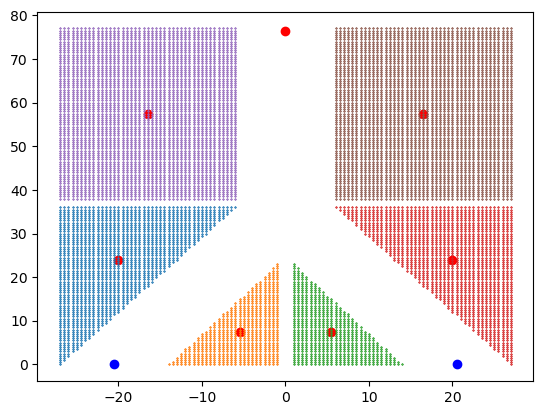

In [20]:
kwant_sites = np.array([site.pos for site in system.trijunction.sites])/scale

dep_index, acc_index = dep_acc_index(
            system.poisson_system,
            kwant_sites,
            system.site_indices,
            system.nw_centers,
            pair,
            True
        )
params.update({'dep_index': dep_index})
params.update({'acc_index': acc_index})


In [22]:
opt_args = tuple([pair, params, kwant_args])
optimization.loss(x, *opt_args)

4.14093548605148e-08

In [44]:
sol1 = minimize(
            codes.optimization.loss,
            x,
            # minimizer_kwargs={'method': 'BFGS',
            #                   'args' : opt_args,
            #                   'options': {'gtol': 1e-1}},
            # disp = True
            args=opt_args,
            method="trust-constr",
            options={
                "verbose": 2,
                "initial_tr_radius": 1e-3,
                "gtol": 1e-1,
            },
        )

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5   |   0   | +6.9627e-03 | 1.00e-03 | 1.84e+00 | 0.00e+00 |
|   2   |  10   |   1   | +4.6312e-03 | 7.00e-03 | 1.84e+00 | 0.00e+00 |
|   3   |  15   |   2   | +6.1474e-04 | 7.00e-03 | 6.30e-01 | 0.00e+00 |
|   4   |  20   |   3   | +6.1474e-04 | 3.50e-03 | 6.30e-01 | 0.00e+00 |
|   5   |  25   |   4   | +6.1474e-04 | 1.74e-03 | 6.30e-01 | 0.00e+00 |
|   6   |  30   |   5   | +6.1474e-04 | 8.69e-04 | 6.30e-01 | 0.00e+00 |
|   7   |  35   |   6   | +4.3789e-06 | 6.08e-03 | 6.30e-01 | 0.00e+00 |
|   8   |  40   |   7   | +4.3789e-06 | 1.17e-03 | 6.30e-01 | 0.00e+00 |
|   9   |  45   |   8   | +4.3789e-06 | 4.70e-04 | 6.30e-01 | 0.00e+00 |
|  10   |  50   |   9   | +4.3789e-06 | 2.21e-04 | 6.30e-01 | 0.00e+00 |
|  11   |  55   |  10   | +4.3789e-06 | 1.10e-04 | 6.30e-01 | 0.00e+00 |
|  12   |  60   |  11   | +4.3789e-06 | 5.51e-05 | 

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  13   |  65   |  12   | +4.3789e-06 | 2.76e-05 | 6.30e-01 | 0.00e+00 |
|  14   |  70   |  13   | +4.3789e-06 | 1.38e-05 | 6.30e-01 | 0.00e+00 |
|  15   |  75   |  14   | +4.3789e-06 | 6.89e-06 | 6.30e-01 | 0.00e+00 |
|  16   |  80   |  15   | +5.2953e-07 | 1.38e-05 | 6.30e-01 | 0.00e+00 |
|  17   |  85   |  16   | +5.2953e-07 | 6.89e-06 | 6.30e-01 | 0.00e+00 |
|  18   |  90   |  17   | +5.2953e-07 | 2.68e-06 | 6.30e-01 | 0.00e+00 |
|  19   |  95   |  18   | +5.2953e-07 | 1.34e-06 | 6.30e-01 | 0.00e+00 |
|  20   |  100  |  19   | +4.2598e-07 | 1.34e-06 | 6.30e-01 | 0.00e+00 |
|  21   |  105  |  20   | +4.2598e-07 | 6.71e-07 | 6.30e-01 | 0.00e+00 |
|  22   |  110  |  21   | +5.1775e-08 | 4.69e-06 | 6.30e-01 | 0.00e+00 |
|  23   |  115  |  22   | +5.1775e-08 | 4.69e-07 | 6.30e-01 | 0.00e+00 |
|  24   |  120  |  23   | +5.1775e-08 | 1.57e-07 | 6.30e-01 | 0.00e+00 |
|  25   |  125  |  24   | +5.1775e-08 | 7.86e-08 | 6.30e-01 | 0.00e+00 |
|  26   |  130  |  25   | +4.2201e-09 | 5.50e-07 | 

### Gradient descent

In [23]:
from scipy.optimize import approx_fprime

In [72]:
import codes.optimization
import importlib
importlib.reload(codes.optimization)

<module 'codes.optimization' from '/home/tinkerer/trijunction-design/analysis/codes/optimization.py'>

In [24]:
x

[-0.003, -0.003, -0.007, 0.003]

In [25]:
approx_fprime(x, optimization.loss, 1e-3, *opt_args)

array([ 1.01179855e+00,  1.01179855e+00, -7.73778248e-08, -1.42946729e-06])

In [55]:
params.update(parameters.voltage_dict(x))
opt_args = tuple([pair, params, kwant_args])

In [56]:
optimiser_args = system.optimiser_arguments()

linear_ham, numerical_hamiltonian = hamiltonian(system.trijunction, 
                                    optimiser_args['linear_terms'], 
                                    optimiser_args['kwant_params_fn'], 
                                    **params)

In [57]:
optimization.soft_threshold(linear_ham, 
                            params['dep_index'], 
                            params['acc_index'],
                            params['mus_nw'][0])

(-0.006962735012777417+0j)

In [49]:
energies, wave_functions = eigsh(
                numerical_hamiltonian.tocsc(),
                6,
                sigma=0,
                return_eigenvectors=True,
)

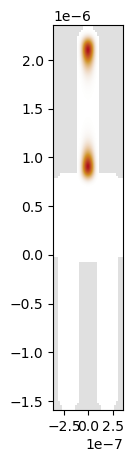

In [50]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5), sharey= True)

density = kwant.operator.Density(system.trijunction, np.eye(4))
for i, vec in enumerate(wave_functions.T[[0]]):
    kwant.plotter.density(system.trijunction, density(vec), ax = ax);

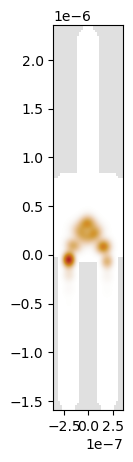

In [130]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5), sharey= True)

density = kwant.operator.Density(system.trijunction, np.eye(4))
for i, vec in enumerate(wave_functions.T[[0]]):
    kwant.plotter.density(system.trijunction, density(vec), ax = ax);

In [144]:
transformed_hamiltonian = svd_transformation(
    energies, wave_functions, system.mlwf[order_wavefunctions('left-right')]
)

desired = np.abs(transformed_hamiltonian[0, 1])
undesired = np.linalg.norm(transformed_hamiltonian[2:])

In [145]:
desired

3.420274824242966e-05

In [139]:
desired

2.9545587357400678e-05

In [83]:
kwant_sites

(28778, 2)

In [85]:
system.site_coords.shape

(16895, 3)